In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy
import umap
from ripser import ripser
from persim import plot_diagrams
import tqdm

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
#cmap = project_cmap()

In [4]:
model = HexagonalGCs(ncells=3)
res = 100
rs = model.unit_cell.mesh(res)

In [5]:
def max_birth_max_death(dgmss):
    flat_dgmss = []
    for dgms in dgmss:
        flat_dgmss += dgms
    flat_x_dgms = np.concatenate([dgms[i][:,0] for i in range(len(dgms))])
    flat_y_dgms = np.concatenate([dgms[i][:,1] for i in range(len(dgms))])
    return np.max(flat_x_dgms), np.max(np.ma.masked_invalid(flat_y_dgms))

In [6]:
phases = np.array([[-0.4,0],[0.2,0.2],[0.2,-0.3]])
phasess = [phases[:1], phases[:2], phases, model.unit_cell.sample(15,seed=2)]
dgmss = []
#manifolds = []
activities = []
colors = []
xmax,ymax = None,None
for phases in tqdm.tqdm(phasess):
    model.set_phases(phases)
    activity = model(torch.tensor(rs,dtype=torch.float32)).detach().numpy()
    #c = activity @ activity[0]
    dgms = ripser(activity,maxdim=2,n_perm=150)['dgms']
    dgmss.append(dgms)
    activities.append(activity)
    colors.append(activity @ activity[0])
    
projection = umap.UMAP(n_neighbors=25,n_components=3)
manifold = projection.fit_transform(activity) # of 15d
#manifolds.append(manifold)

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.98it/s]


In [76]:
def ripsers(axs, dgmss,xmargin=1.3,ymargin=1.2):
    xmax, ymax = max_birth_max_death(dgmss)
    for i in range(len(axs)):
        axs[i].plot(np.linspace(0,xmax*xmargin,2),np.linspace(0,xmax*xmargin,2),
                    linewidth=0.4,color='grey')#,ls=':')    
        axs[i].set_xlim([-0.1,xmax*xmargin])
        axs[i].set_ylim([-0.1,ymax*ymargin])
        axs[i].set_xticks([0,round(xmax)])
        axs[i].set_yticks([0,round(ymax)])
        axs[i].xaxis.tick_top()
        axs[i].spines['top'].set_visible(True)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].patch.set_alpha(0)
        if i > 0:
            #axs[i].set_yticks([])
            axs[i].axis('off')
        for b,cocycle in enumerate(dgmss[i]):
            if b==0:
                cocycle = np.append(cocycle,np.array([[0,ymax*(ymargin-0.05)]]),axis=0)
            axs[i].scatter(*cocycle.T,s=5)

# for 1,2,3d dont use umap?
def plot_manifolds(axs):
    axs[0].scatter(np.zeros(res**2),activities[0][:,0],s=0.01,c=colors[0])
    axs[1].scatter(*activities[1].T,s=0.01,c=colors[0])
    axs[2].scatter(*activities[2].T,s=0.01,c=colors[0])
    axs[-1].scatter(*manifold.T,s=0.01,c=colors[0])
    [ax.axis('off') for ax in axs]
    [ax.patch.set_alpha(0) for ax in axs]
    return axs

def plot_phases(axs):
    for i in range(len(axs)):
        axs[i].scatter(*phasess[i].T)
        model.unit_cell.plot(ax=axs[i],color='black',linewidth=0.4)
        [ax.axis('off') for ax in axs]
        [ax.patch.set_alpha(0) for ax in axs]
    return axs

In [77]:
def fix_axis(dgms,ax,wspace=0.1,maxval_fraction=0.2):
    dgms[0][-1,1] = dgms[0][-2,1]
    flat_x_dgms = np.concatenate([dgms[i][:,0] for i in range(len(dgms))])
    flat_y_dgms = np.concatenate([dgms[i][:,1] for i in range(len(dgms))])
    xmin, xmax = np.min(flat_x_dgms), np.max(flat_x_dgms)
    ymin, ymax = 0, np.max(flat_y_dgms)
    x_wspace = xmax*wspace
    return xmin-x_wspace, xmax+x_wspace, ymin, ymax*(1+maxval_fraction)

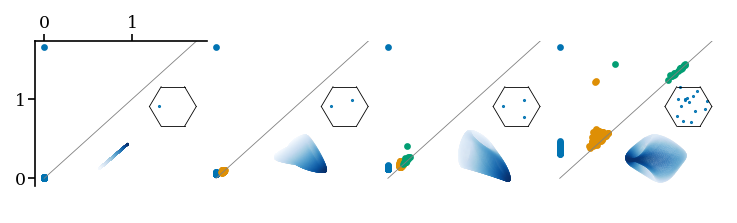

In [91]:
# OBS - CHANGE SUCH THAT RIPSER IS PLOTTED FIRST AND MANIFOLD IS INSET (less whitespace)

# plotting inits
figsize = set_size(fraction=(1,1/4),mode='square')
fig,axs = plt.subplots(ncols=4,figsize=figsize,dpi=150)#,subplot_kw={"projection": "3d"})
#plt.subplots_adjust(top=1,bottom=0,right=1,left=0,wspace=-0.6,hspace=-0)
#[axs[i].set_position((0.23*i+padding*i,0+padding,0.23,1-0.15-padding)) for i in range(len(axs))];

padding = 0.02
offset = 0.04
fractions = (1-offset)/4
[axs[i].set_position((offset+fractions*i,0,fractions,1-0.15-offset)) for i in range(len(axs))];

#axins = [ax.inset_axes(bounds=(0.2,-0.15,0.7,0.7),projection='3d') for ax in axs]
#axins = [ax.inset_axes(bounds=(0.2,-0.15,0.7,0.7),projection='3d') for ax in axs]
axins = [
    axs[0].inset_axes(bounds=(0.1,-0.15,0.7,0.7),projection='3d'),
    axs[1].inset_axes(bounds=(0.25,-0.13,0.7,0.7),projection='3d'),
    axs[2].inset_axes(bounds=(0.32,-0.1,0.7,0.7),projection='3d'),
    axs[3].inset_axes(bounds=(0.25,-0.15,0.7,0.7),projection='3d')
]
axins2 = [ax.inset_axes(bounds=(0.65,0.4,0.3,0.3)) for ax in axs]
#axins = [ax.inset_axes(bounds=(0.4,0.1,0.7,0.7),projection='3d') for ax in axs]
#axins2 = [ax.inset_axes(bounds=(0.3,0,0.3,0.3)) for ax in axs]

ripsers(axs,dgmss)
plot_manifolds(axins);
plot_phases(axins2);
fig.savefig('../results/ncells-manifolds.png')#,bbox_inches='tight')#,dpi=150)

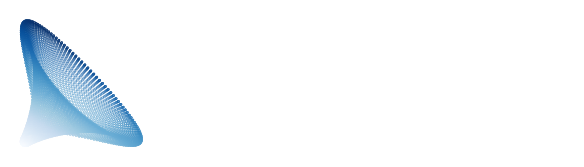

In [10]:
# plotting inits
figsize = set_size(fraction=(1,1/4),mode='square')
fig,axs = plt.subplots(ncols=4,figsize=figsize)
[ax.axis('off') for ax in axs];
plt.subplots_adjust(wspace=0.06,hspace=0)

hex_mesh = model.unit_cell.mesh(100)
activity = model(torch.tensor(hex_mesh,dtype=torch.float32)).detach().numpy()
c = activity[:,:2] @ activity[0,:2]
c -= np.min(c)
c /= np.max(c)

axs[0].scatter(*activity[:,:2].T,s=0.02,c=c)

TypeError: scatter() got multiple values for argument 'c'

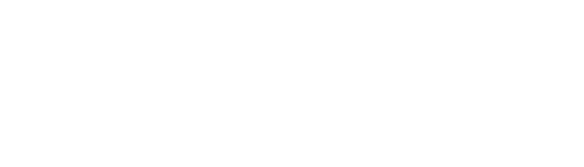

In [11]:
# plotting inits
figsize = set_size(fraction=(1,1/4),mode='square')
fig,axs = plt.subplots(ncols=4,figsize=figsize,subplot_kw={"projection": "3d"})
[ax.axis('off') for ax in axs];
plt.subplots_adjust(wspace=0,hspace=0)

hex_mesh = model.unit_cell.mesh(200)
activity = model(torch.tensor(hex_mesh,dtype=torch.float32)).detach().numpy()
c = activity @ activity[0]
c -= np.min(c)
c /= np.max(c)

axs[0].scatter(*activity.T,c=c);